In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import fwht,ifwht
import pickle
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from scipy.spatial import distance
import timeit
from scipy.linalg import hadamard
import pandas as pd

In [2]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [35]:
def ConstructProposedQ(file, nCliffs, nQ, nseeds, average=False, directory="AllInputsData/"):
    #load Data
    dbfile=open(directory+file,"rb")
    data=pickle.load(dbfile)
    dbfile.close()
    
    # shuffle Data
    data2 = np.zeros(data.shape)
    for m in range(len(nCliffs)):
        for i in range(nseeds):
            for j in range(2**nQ):
                for k in range(2**nQ):
                    data2[m,i,j,k] = data[m,i,j^k,k]
    data=data2
    
    # Average Data
    data_ave = np.mean(data,axis=1)
    
    # Perform Walsh Hadamard transform on each q(m,|in>)
    # to get Lambda(m)
    H=np.zeros((len(nCliffs),2**nQ,2**nQ))
    for i in range(len(nCliffs)):
        for j in range(2**nQ):
            H[i,:,j]=fwht(data_ave[i,:,j])
            
    # For each parameter in Lambda(m) for each input
    # Fit to get A_i and alpha_i
    A=np.zeros((2**nQ,2**nQ))
    alpha=np.zeros((2**nQ,2**nQ))
    for i in range(2**nQ):
        for j in range(2**nQ):
            model=LinearRegression()
            model.fit(nCliffs.reshape(-1,1),np.log(H[:,i,j]))
            A[i,j],alpha[i,j]=model.intercept_,model.coef_
    
    # Transform A_i into a diagonal matrix
    A=np.exp(A)
    alpha=np.exp(alpha)
    A2=np.zeros((2**nQ,2**nQ,2**nQ))
    for i in range(2**nQ):
        A2[i,:,:]=np.diag(A[:,i])
    A=A2
    A.shape

    # Perform Inverse Walsh Hadamard Transform on alpha
    # to get the error rate vector p
    p=np.zeros((2**nQ,2**nQ))
    for i in range(2**nQ):
        p[:,i]=projection_simplex_sort(np.array(ifwht(alpha[:,i])))
        
    # Shuffle the p vector
    # to get the M matrix for input |0>
    M = np.zeros((2**nQ,2**nQ,2**nQ))
    if average == True:
        p_ave=np.mean(p,axis=1)
        for k in range(2**nQ):
            for i in range(2**nQ):
                for j in range(2**nQ):
                    M[k,i,j]=p_ave[i^j]
    
    else:
        for k in range(2**nQ):
            for i in range(2**nQ):
                for j in range(2**nQ):
                    M[k,i,j]=p[i^j,k]
    
    # Calculate N_{in} = W^(-1)A_{in}W for each input
    N = np.zeros((2**nQ,2**nQ,2**nQ))
    W = hadamard(2**nQ)
    W_inverse = np.linalg.inv(W)
    for j in range(2**nQ):
        N[j,:,:]=np.dot(W_inverse,A[j,:,:])
        N[j,:,:]=np.dot(N[j,:,:],W)
    
    # Calculate the estimated average q'(m) = (W^-1)(A)(W)(M^m)|in> for each depth m and in
    estimated_ave=np.zeros((len(nCliffs),2**nQ,2**nQ,2**nQ))
    for m in range(len(nCliffs)):
        for i in range(2**nQ):
            estimated_ave[m,i,:,:]=np.linalg.matrix_power(M[i,:,:],nCliffs[m])
            estimated_ave[m,i,:,:]=np.dot(N[i,:,:],estimated_ave[m,i,:,:])
            for j in range(2**nQ):
                estimated_ave[m,i,:,j]=projection_simplex_sort(estimated_ave[m,i,:,j])
    
    # Constructing Q
    Q=np.zeros((len(nCliffs),2**nQ,2**nQ))
    for m in range(len(nCliffs)):
        for j in range(2**nQ):
            input_vec=np.zeros(2**nQ)
            input_vec[j]=1
            Q[m,:,j]=np.dot(estimated_ave[m,j,:,:],input_vec)
    
    return M,N,Q

In [36]:
def ProposedJSD(file, M, N, Q, nCliffs, nQ, nseeds, directory="AllInputsData/"):    
    # Computing Q_inverse
    Q_inverse=np.zeros((len(nCliffs),2**nQ,2**nQ))
    for m in range(len(nCliffs)):
        Q_inverse[m,:,:]=np.linalg.inv(Q[m,:,:])
    
    
    # Loading Data
    dbfile=open(directory+file,"rb")
    data=pickle.load(dbfile)
    dbfile.close()
    
    # Mitigating data using Q_inverse
    data_mitigated=np.zeros(data.shape)
    for m in range(len(nCliffs)):
        for i in range(nseeds):
            for j in range(2**nQ):
                data_mitigated[m,i,:,j]=np.dot(Q_inverse[m,:,:],data[m,i,:,j])
                data_mitigated[m,i,:,j]=projection_simplex_sort(data_mitigated[m,i,:,j])
                
    # Computing JSD between data_mitigated and ideal output
    JSD=np.zeros((len(nCliffs),nseeds,2**nQ))
    for m in range(len(nCliffs)):
        for i in range(nseeds):
            for j in range(2**nQ):
                input_vec=np.zeros(2**nQ)
                input_vec[j]=1
                JSD[m,i,j]=distance.jensenshannon(input_vec,data_mitigated[m,i,:,j])

    return JSD

In [37]:
def UnmitigatedJSD(file, nCliffs, nQ, nseeds, directory="AllInputsData/"):
    # Loading data
    dbfile = open(directory+file,"rb")
    data = pickle.load(dbfile)
    dbfile.close()
    
    # Computing JSD between unmitigated outputs and ideal ouput
    JSD=np.zeros((len(nCliffs),nseeds,2**nQ))
    for m in range(len(nCliffs)):
        for i in range(nseeds):
            for j in range(2**nQ):
                input_vec=np.zeros(2**nQ)
                input_vec[j]=1
                JSD[m,i,j]=distance.jensenshannon(input_vec,data[m,i,:,j])
    
    return JSD

In [38]:
def QiskitJSD(file, qiskit_file, nCliffs, nQ, nseeds, qiskit_directory="QiskitData/", directory="AllInputsData/"):
    dbfile = open(directory+file,"rb")
    data = pickle.load(dbfile)
    dbfile.close()
    
    dbfile = open(qiskit_directory+qiskit_file,"rb")
    qiskit_Q_matrix = pickle.load(dbfile)
    dbfile.close()
    
    # Mitigating data using qiskit_Q_inverse
    qiskit_Q_matrix_inverse=np.linalg.inv(qiskit_Q_matrix)
    qiskit_data_mitigated=np.zeros(data.shape)
    for m in range(len(nCliffs)):
        for i in range(nseeds):
            for j in range(2**nQ):
                qiskit_data_mitigated[m,i,:,j]=np.dot(qiskit_Q_matrix_inverse,data[m,i,:,j])
                qiskit_data_mitigated[m,i,:,j]=projection_simplex_sort(qiskit_data_mitigated[m,i,:,j])
    
    # Computing JSD between data_mitigated and ideal output
    JSD=np.zeros((len(nCliffs),nseeds,2**nQ))
    for m in range(len(nCliffs)):
        for i in range(nseeds):
            for j in range(2**nQ):
                input_vec=np.zeros(2**nQ)
                input_vec[j]=1
                JSD[m,i,j]=distance.jensenshannon(input_vec,qiskit_data_mitigated[m,i,:,j])
    
    return JSD

In [39]:
def InterpolatationJSD(inter_file, inter_nCliffs, M, N, nQ, inter_directory="InterpolationData/"):
    # Load interpolated data
    dbfile=open(inter_directory+inter_file,"rb")
    inter_data=pickle.load(dbfile)
    dbfile.close()
    
    # Calculate the estimated average q'(m) = (W^-1)(A)(W)(M^m)|in> for each depth m in interpolation set and in
    estimated_ave=np.zeros((len(inter_nCliffs),2**nQ,2**nQ,2**nQ))
    for m in range(len(inter_nCliffs)):
        for i in range(2**nQ):
            estimated_ave[m,i,:,:]=np.linalg.matrix_power(M[i,:,:],inter_nCliffs[m])
            estimated_ave[m,i,:,:]=np.dot(N[i,:,:],estimated_ave[m,i,:,:])
            for j in range(2**nQ):
                estimated_ave[m,i,:,j]=projection_simplex_sort(estimated_ave[m,i,:,j])
    
    # Constructing Q  for m in inter_nCliffs
    Q=np.zeros((len(inter_nCliffs),2**nQ,2**nQ))
    for m in range(len(inter_nCliffs)):
        for j in range(2**nQ):
            input_vec=np.zeros(2**nQ)
            input_vec[j]=1
            Q[m,:,j]=np.dot(estimated_ave[m,j,:,:],input_vec)
    
    # Constructing Q_invers
    Q_inverse=np.zeros(Q.shape)
    for m in range(len(inter_nCliffs)):
        Q_inverse[m,:,:]=np.linalg.inv(Q[m,:,:])
    
    # Mitigating data using Q_inverse
    data_mitigated=np.zeros(inter_data.shape)
    for m in range(len(inter_nCliffs)):
        for i in range(inter_nseeds):
            for j in range(2**nQ):
                data_mitigated[m,i,:,j]=np.dot(Q_inverse[m,:,:],inter_data[m,i,:,j])
                data_mitigated[m,i,:,j]=projection_simplex_sort(data_mitigated[m,i,:,j])
                
    # Computing JSD between data_mitigated and ideal output
    JSD=np.zeros((len(inter_nCliffs),inter_nseeds,2**nQ))
    for m in range(len(inter_nCliffs)):
        for i in range(inter_nseeds):
            for j in range(2**nQ):
                input_vec=np.zeros(2**nQ)
                input_vec[j]=1
                JSD[m,i,j]=distance.jensenshannon(input_vec,data_mitigated[m,i,:,j])
    
    return JSD

In [40]:
nQ=5
nseeds = 1000
shots = 1024
nCliffs = np.array([1,20,40,60,80,100])
inter_nseeds = 100
inter_nCliffs=np.array([10,30,50,70,90])
computer = "Lima"


unmitigated_JSD = UnmitigatedJSD(computer+"All", nCliffs, nQ, nseeds, directory="InterpolationData/")
M,N,Q = ConstructProposedQ(computer+"All", nCliffs, nQ, nseeds, average=False, directory="AllInputsData/")
proposed_JSD = ProposedJSD(computer+"All", M, N, Q, nCliffs, nQ, nseeds, directory="AllInputsData/")
qiskit_JSD = QiskitJSD(computer+"All",computer+"Qiskit",nCliffs, nQ, nseeds, qiskit_directory="QiskitData/", directory="InterpolationData/")

# Interpolation
inter_unmitigated_JSD = UnmitigatedJSD(computer+"Interpolation", inter_nCliffs, nQ, inter_nseeds, directory="InterpolationData/")
inter_proposed_JSD = InterpolatationJSD(computer+"Interpolation", inter_nCliffs, M, N, nQ, inter_directory="InterpolationData/")
inter_qiskit_JSD = QiskitJSD(computer+"Interpolation", computer+"Qiskit", inter_nCliffs, nQ, inter_nseeds, qiskit_directory="QiskitData/", directory="InterpolationData/")

<ipython-input-41-5250b784f2e5>:24: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(inter_nCliffs,inter_unmitigated_ave_JSD,color=p0[0].get_color(),marker='d',linestyle='',Markersize=3)
<ipython-input-41-5250b784f2e5>:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(nCliffs,unmitigated_ave_JSD,color=p0[0].get_color(),marker='o',linestyle='',Markersize=3)
<ipython-input-41-5250b784f2e5>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(inter_nCliffs,inter_qiskit_ave_JSD,color=p0[0].get_color(),marker='d',linestyle='',Markersize=3)
<ipython-input-41-5250b784f2e5>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases late

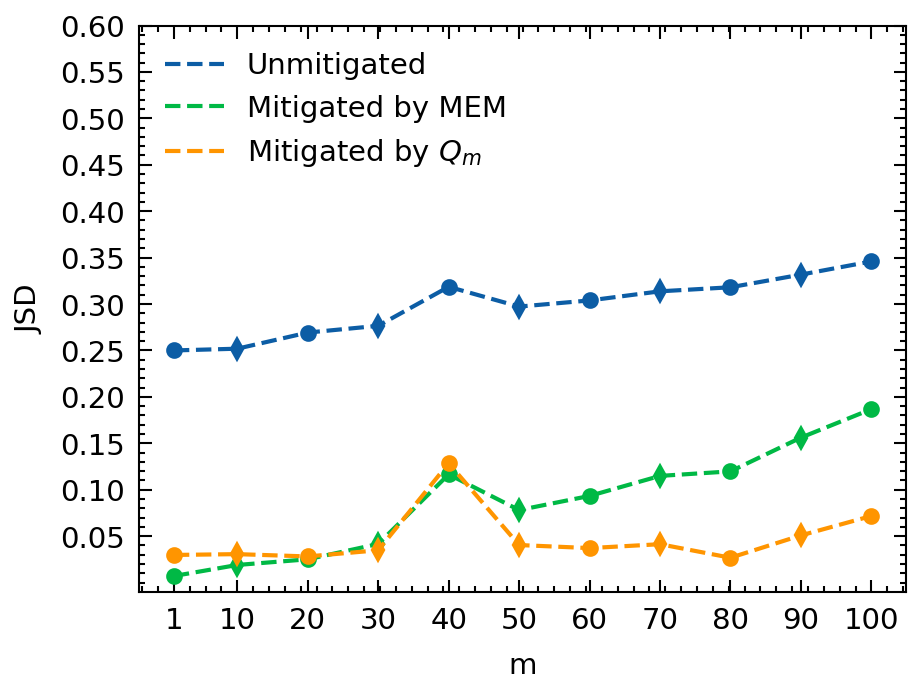

In [41]:
plt.style.use(['science','no-latex','nature'])

nCliffs2=[1,10,20,30,40,50,60,70,80,90,100]
order=[0,6,1,7,2,8,3,9,4,10,5]

unmitigated_ave_JSD = np.mean(unmitigated_JSD, axis=(1,2))
proposed_ave_JSD = np.mean(proposed_JSD, axis=(1,2))
qiskit_ave_JSD = np.mean(qiskit_JSD, axis=(1,2))

inter_unmitigated_ave_JSD = np.mean(inter_unmitigated_JSD, axis=(1,2))
inter_proposed_ave_JSD = np.mean(inter_proposed_JSD, axis=(1,2))
inter_qiskit_ave_JSD = np.mean(inter_qiskit_JSD, axis=(1,2))

unmitigated=list(unmitigated_ave_JSD)+list(inter_unmitigated_ave_JSD)
qiskit=list(qiskit_ave_JSD)+list(inter_qiskit_ave_JSD)
proposed=list(proposed_ave_JSD)+list(inter_proposed_ave_JSD)

unmitigated=[unmitigated[i] for i in order]
qiskit=[qiskit[i] for i in order]
proposed=[proposed[i] for i in order]

fig, ax = plt.subplots(dpi=300)
p0=plt.plot(nCliffs2,unmitigated,linestyle='--',label='Unmitigated')
plt.plot(inter_nCliffs,inter_unmitigated_ave_JSD,color=p0[0].get_color(),marker='d',linestyle='',Markersize=3)
plt.plot(nCliffs,unmitigated_ave_JSD,color=p0[0].get_color(),marker='o',linestyle='',Markersize=3)

p0=plt.plot(nCliffs2,qiskit,linestyle='--',label='Mitigated by MEM')
plt.plot(inter_nCliffs,inter_qiskit_ave_JSD,color=p0[0].get_color(),marker='d',linestyle='',Markersize=3)
plt.plot(nCliffs,qiskit_ave_JSD,color=p0[0].get_color(),marker='o',linestyle='',Markersize=3)

p0=plt.plot(nCliffs2,proposed,linestyle='--',label=r'Mitigated by $Q_m$')
plt.plot(inter_nCliffs,inter_proposed_ave_JSD,color=p0[0].get_color(),marker='d',linestyle='',Markersize=3)
plt.plot(nCliffs,proposed_ave_JSD,color=p0[0].get_color(),marker='o',linestyle='',Markersize=3)

plt.yticks([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6])
plt.xlabel('m')
plt.ylabel('JSD')
plt.xticks([1,10,20,30,40,50,60,70,80,90,100])
plt.legend(loc='upper left')
#plt.savefig('LimaAllInputs')

No handles with labels found to put in legend.


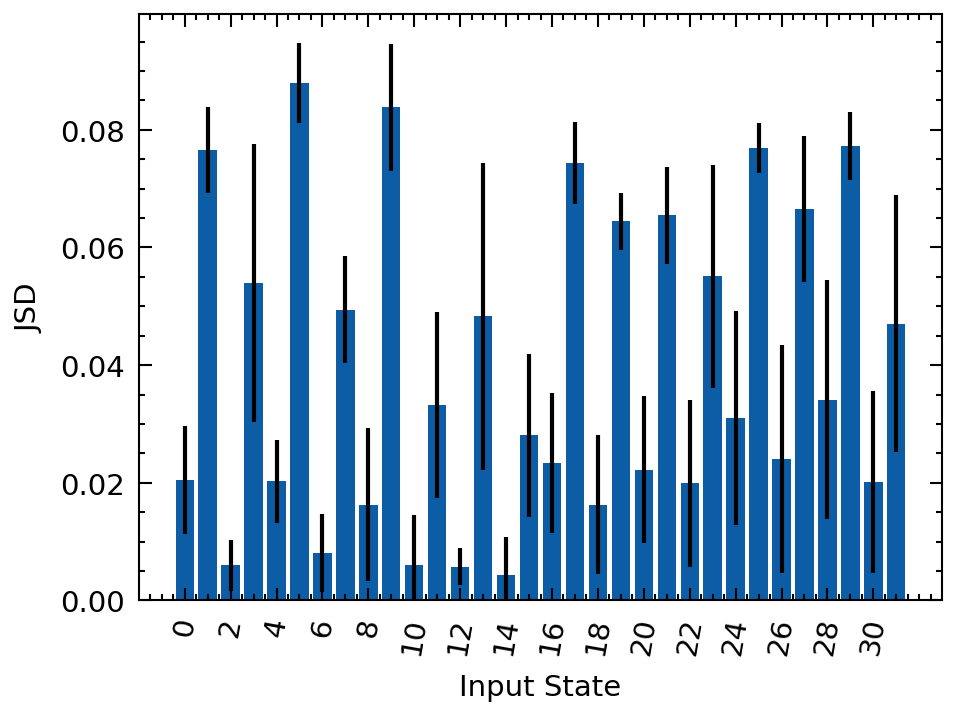

In [52]:
proposed_ave_JSD = np.mean(proposed_JSD, axis=1)

inter_proposed_ave_JSD = np.mean(inter_proposed_JSD, axis=1)

nCliffs2=[1,10,20,30,40,50,60,70,80,90,100]
order=[0,6,1,7,2,8,3,9,4,10,5]

proposed=np.concatenate([proposed_ave_JSD, inter_proposed_ave_JSD])

proposed=np.array([proposed[i,:] for i in order])

plt.style.use(['science','no-latex','nature'])
ave_JSD=np.mean(proposed[[1,3,5,7,9]],axis=0)
std_JSD=np.std(proposed[[1,3,5,7,9]],axis=0)

labels=[]
for i in range(2**nQ):
    labels.append(i)

x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(dpi=300)
rects1 = ax.bar(x, ave_JSD, width,yerr=std_JSD)

ax.set_ylabel('JSD')

labels=[]
for i in range(2**nQ):
    if i%2==0:
        labels.append(i)

ax.set_xticks(labels)
ax.set_xlabel('Input State')
ax.set_xticklabels(labels,)
ax.legend(loc='upper left')
ax.set_ylim(ymin=0)
plt.xticks(rotation=80)

fig.tight_layout()
#plt.savefig('ManilaAllInputsTestErrorBars',dpi=300)